Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#notebookの中にグラフを描くため
%matplotlib inline
#グラフでマイナスが壊れるの防止
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('pydataenv/data/bike-sharing-demand/train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('pydataenv/data/bike-sharing-demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = train['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

<AxesSubplot:title={'center':'test windspeed'}, xlabel='windspeed', ylabel='count'>

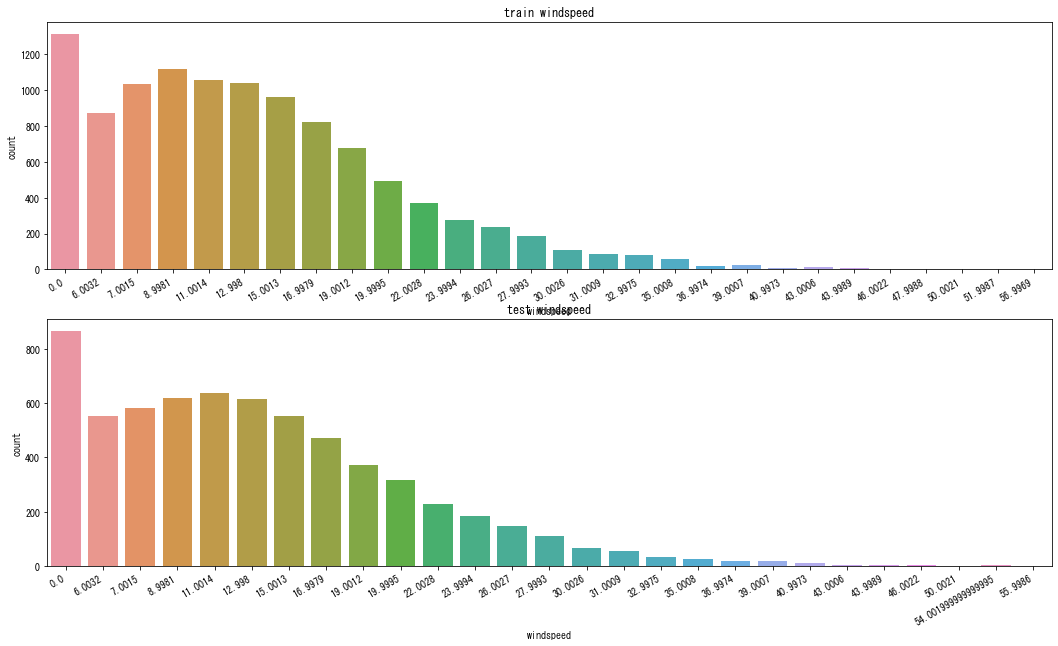

In [6]:
#widspeedの0 => 修正が必要
fig, axes = plt.subplots(2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

In [7]:
#0の処理
# trainWind0 = train.loc[train['windspeed'] == 0]
# trainNotWind0 = train.loc[train['windspeed'] != 0]
# print(trainWind0)
# print(trainNotWind0)

In [8]:
#MLで予測してwindを入れる
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    #windが０とnot０を区分
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    #予測するピッチャーを選択
    wCol = ['season','weather','humidity','month','temp','year','atemp']
    
    #windが０ではなおデータのtypeをstrに変更
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    #RnadomForest使用
    rfModel_wind = RandomForestClassifier()
    
    #wColの値をベースにしてwindを学習させる
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])

    #学習したデータでwindを予測する
    wind0Values = rfModel_wind.predict(X=dataWind0[wCol])
    
    #予測後、比較のため
    #予測値を入れるデータフレームを作成
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    #値が0であるwindの予測値を入れる
    predictWind0['windspeed'] = wind0Values
    
    #dataWindNot0 0ではないwindのデータフレームをmerge
    data = predictWindNot0.append(predictWind0)
    
    #windのtypeをfloatの変更
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

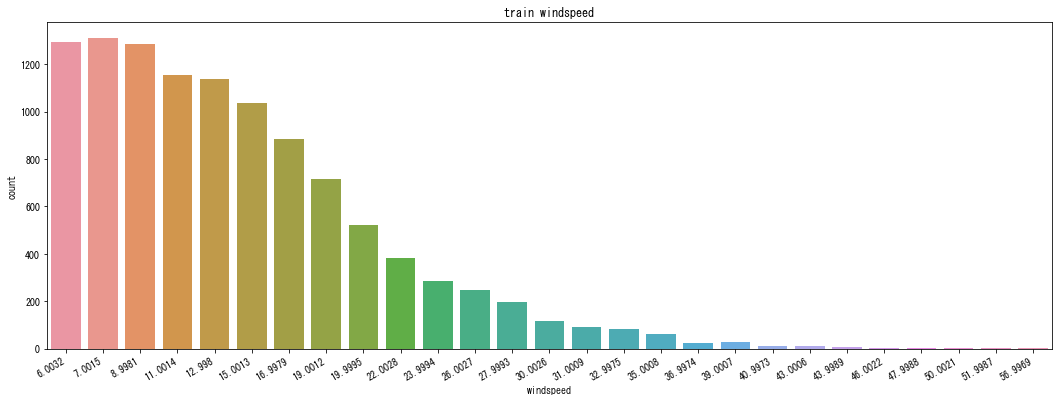

In [9]:
#0値を調整
train = predict_windspeed(train)
train
#wind 0値変更後データ視覚化
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

In [10]:
#連続featureとカテゴリーfeature
#連続=['temp','atemp','windspeed','humidity']
#カテゴリーfeatureのtypeをcategoryに変更
categorical_feature_names = ['season','holiday','workingday','weather',
                             'dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [11]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed',
                 'year','hour','dayofweek','holiday','workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [12]:
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [13]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [14]:
label_name = 'count'

y_train = train[label_name]
print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

Evaluation

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msqrt>
    <mfrac>
      <mn>1</mn>
      <mi>n</mi>
    </mfrac>
    <munderover>
      <mo>&#x2211;<!-- ∑ --></mo>
      <mrow class="MJX-TeXAtom-ORD">
        <mi>i</mi>
        <mo>=</mo>
        <mn>1</mn>
      </mrow>
      <mi>n</mi>
    </munderover>
    <mo stretchy="false">(</mo>
    <mi>log</mi>
    <mo>&#x2061;<!-- ⁡ --></mo>
    <mo stretchy="false">(</mo>
    <msub>
      <mi>p</mi>
      <mi>i</mi>
    </msub>
    <mo>+</mo>
    <mn>1</mn>
    <mo stretchy="false">)</mo>
    <mo>&#x2212;<!-- − --></mo>
    <mi>log</mi>
    <mo>&#x2061;<!-- ⁡ --></mo>
    <mo stretchy="false">(</mo>
    <msub>
      <mi>a</mi>
      <mi>i</mi>
    </msub>
    <mo>+</mo>
    <mn>1</mn>
    <mo stretchy="false">)</mo>
    <msup>
      <mo stretchy="false">)</mo>
      <mn>2</mn>
    </msup>
  </msqrt>
</math>

In [15]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    #np公式に変更
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    #予測値と実際値に+1をしてlogを被る
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    #上の予測値で実際値を - する, 二乗する
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    #平均値を計算
    mean_difference = difference.mean()
    
    #sqrt値
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [16]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

RandomForest

In [17]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=0)
model

RandomForestRegressor(n_jobs=-1, random_state=0)

In [18]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
#0に近いほどいいデータ
print('Score={0:.5f}'.format(score))

Wall time: 20.1 s
Score=0.33083


Train

In [19]:
#学習する
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [20]:
#予測
predictions = model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.29,   5.01,   4.09,   3.52,   3.22,   6.07,  38.2 , 104.97,
       236.71, 136.03])

[Text(0.5, 1.0, 'test')]

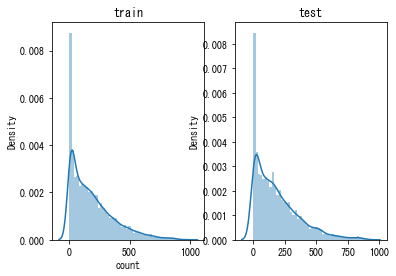

In [21]:
#予測したデータを視覚化する
fit, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)

sns.distplot(y_train,ax=ax1,bins=50)
ax1.set(title='train')

sns.distplot(predictions,ax=ax2,bins=50)
ax2.set(title='test')

In [22]:
submission = pd.read_csv('pydataenv/data/bike-sharing-demand/sampleSubmission.csv')
# submission['count'].shape
# predictions.shape
# predictions.shape
submission['count'] = predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.29
1,2011-01-20 01:00:00,5.01
2,2011-01-20 02:00:00,4.09
3,2011-01-20 03:00:00,3.52
4,2011-01-20 04:00:00,3.22


In [24]:
submission.to_csv('pydataenv/data/bike-sharing-demand/Score_{0:.5f}_submission.csv'.format(score), index=False)